In [1]:
import torch

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


### Data Preprocessing

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [7]:
df=pd.read_csv('KaggleV2-May-2016.csv')
df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   PatientId       110527 non-null  float64
 1   AppointmentID   110527 non-null  int64  
 2   Gender          110527 non-null  object 
 3   ScheduledDay    110527 non-null  object 
 4   AppointmentDay  110527 non-null  object 
 5   Age             110527 non-null  int64  
 6   Neighbourhood   110527 non-null  object 
 7   Scholarship     110527 non-null  int64  
 8   Hipertension    110527 non-null  int64  
 9   Diabetes        110527 non-null  int64  
 10  Alcoholism      110527 non-null  int64  
 11  Handcap         110527 non-null  int64  
 12  SMS_received    110527 non-null  int64  
 13  No-show         110527 non-null  object 
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


#### Dropping unwanted columns

In [8]:
df.drop(columns=['PatientId','AppointmentID','ScheduledDay','AppointmentDay'],inplace=True)
df.head()

,Gender,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,F,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,M,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,F,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,F,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,F,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [ ]:
df['No-show'].value_counts()
# The target class is imbalanced in the ratio of 4:1 which is high class imbalance in the dataset

No-show
No     88208
Yes    22319
Name: count, dtype: int64

#### Label Encoding 

In [13]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
df['Gender']=le.fit_transform(df['Gender'])
df['No-show']=le.fit_transform(df['No-show'])
df['Neighbourhood']=le.fit_transform(df['Neighbourhood'])

In [14]:
# separating the features and target
X=df.drop(columns=['No-show'])
y=df['No-show']

X.shape,y.shape

((110527, 9), (110527,))

#### Feature Scaling

In [15]:
from sklearn.preprocessing import StandardScaler
scalar=StandardScaler()
X=scalar.fit_transform(X)

#### Splitting into train and validation dataset

In [16]:
from sklearn.model_selection import train_test_split
X_train,X_val,y_train,y_val=train_test_split(X,y,test_size=0.2,stratify=y)
X_train.shape,X_val.shape,y_train.shape,y_val.shape

((88421, 9), (22106, 9), (88421,), (22106,))

#### Part 1: From Scratch Implementation

In [17]:
input_size=X_train.shape[1]

In [31]:
X_train.shape,X_val.shape,y_train.shape,y_val.shape

((88421, 9), (22106, 9), (88421,), (22106,))

In [46]:
from sklearn.utils.class_weight import compute_class_weight

classes = np.unique(y_train)
weights = compute_class_weight('balanced', classes=classes, y=y_train)
class_weights = {0: weights[0], 1: weights[1]}

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, f1_score, roc_auc_score, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

def initialize_parameters(input_size, hidden_layers=[128, 64]):
     
    weights = []
    biases = []
    layers = [input_size] + hidden_layers + [1]  
    
    for i in range(len(layers)-1):
        weights.append(np.random.randn(layers[i], layers[i+1]) * 0.01)
        biases.append(np.zeros((1, layers[i+1])))
    
    return weights, biases

def sigmoid(x):
     
    return 1 / (1 + np.exp(-x))

def forward_propagation(X, weights, biases):
     
    activations = [X]
    z_layers = []
    
    for i in range(len(weights)):
        z = np.dot(activations[-1], weights[i]) + biases[i]
        a = sigmoid(z) if i < len(weights)-1 else z   
        z_layers.append(z)
        activations.append(a)
    
    return activations, z_layers

def compute_weighted_loss(y_true, y_pred, class_weights):
    
    y_true = np.asarray(y_true).reshape(-1, 1)
    y_pred = np.asarray(y_pred).reshape(-1, 1)
    sample_weights = np.where(y_true == 1, class_weights[1], class_weights[0])
    return np.mean(sample_weights * (y_true - y_pred)**2)

def backward_propagation(X, y, activations, z_layers, weights, biases, class_weights):
    
    m = X.shape[0]
    y = np.array(y).reshape(-1, 1)
    
    grads_w = [np.zeros_like(w) for w in weights]
    grads_b = [np.zeros_like(b) for b in biases]
    
    sample_weights = np.where(y == 1, class_weights[1], class_weights[0])
    dA = 2 * sample_weights * (activations[-1] - y) / m
    
    grads_w[-1] = np.dot(activations[-2].T, dA)
    grads_b[-1] = np.sum(dA, axis=0, keepdims=True)
    
    for l in range(len(weights)-2, -1, -1):
        dZ = dA * (activations[l+1] * (1 - activations[l+1]))
        grads_w[l] = np.dot(activations[l].T, dZ)
        grads_b[l] = np.sum(dZ, axis=0, keepdims=True)
        dA = np.dot(dZ, weights[l].T)
    
    return grads_w, grads_b

def update_parameters(weights, biases, grads_w, grads_b, learning_rate=0.01):
     
    for i in range(len(weights)):
        weights[i] -= learning_rate * grads_w[i]
        biases[i] -= learning_rate * grads_b[i]
    return weights, biases

def train(X_train, X_val, y_train, y_val, epochs=100, learning_rate=0.001, 
          hidden_layers=[128, 64], class_weights=None):
     
    X_train = np.array(X_train, dtype=np.float32)
    y_train = np.array(y_train).reshape(-1, 1)
    X_val = np.array(X_val, dtype=np.float32)
    y_val = np.array(y_val).reshape(-1, 1)
    
    if class_weights is None:
        class_weights = {0: 1.0, 1: 1.0}
    
    
    input_size = X_train.shape[1]
    weights, biases = initialize_parameters(input_size, hidden_layers)
    
    best_weights, best_biases = None, None
    best_val_loss = float('inf')
    
    for epoch in range(epochs):
        
        activations, z_layers = forward_propagation(X_train, weights, biases)
          
        train_loss = compute_weighted_loss(y_train, activations[-1], class_weights)
        val_activations, _ = forward_propagation(X_val, weights, biases)
        val_loss = compute_weighted_loss(y_val, val_activations[-1], class_weights)
          
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_weights = [w.copy() for w in weights]
            best_biases = [b.copy() for b in biases]
        
        grads_w, grads_b = backward_propagation(
            X_train, y_train, activations, z_layers, weights, biases, class_weights
        )
        
        weights, biases = update_parameters(weights, biases, grads_w, grads_b, learning_rate)
        
        if epoch % 10 == 0:
            print(f"Epoch {epoch}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}")
    
    print(f"Training complete. Best Val Loss: {best_val_loss:.4f}")
    return best_weights, best_biases

def evaluate_model(X_test, y_test, weights, biases, threshold=0.5):
     
    activations, _ = forward_propagation(X_test, weights, biases)
    y_pred_cont = activations[-1]
    
    y_pred_bin = (y_pred_cont > threshold).astype(int)
    
    metrics = {
        'classification_report': classification_report(y_test, y_pred_bin),
        'f1_score': f1_score(y_test, y_pred_bin),
        'roc_auc': roc_auc_score(y_test, y_pred_cont),   
        'confusion_matrix': confusion_matrix(y_test, y_pred_bin)
    }
    
    return metrics


In [48]:
from sklearn.utils.class_weight import compute_class_weight

classes = np.unique(y_train)
weights = compute_class_weight('balanced', classes=classes, y=y_train)
class_weights = {0: weights[0], 1: weights[1]}

In [50]:
# 3. Train the model
trained_weights, trained_biases = train(
    X_train, X_val, y_train, y_val,
    epochs=100,
    learning_rate=0.001,
    class_weights=class_weights
)

# 4. Evaluate
metrics = evaluate_model(X_val, y_val, trained_weights, trained_biases)
print("Classification Report:\n", metrics['classification_report'])
print("F1 Score:", metrics['f1_score'])
print("ROC AUC:", metrics['roc_auc'])
print("Confusion Matrix:\n", metrics['confusion_matrix'])

Epoch 0: Train Loss = 0.5000, Val Loss = 0.5000
Epoch 10: Train Loss = 0.3707, Val Loss = 0.3707
Epoch 20: Train Loss = 0.3048, Val Loss = 0.3048
Epoch 30: Train Loss = 0.2739, Val Loss = 0.2739
Epoch 40: Train Loss = 0.2601, Val Loss = 0.2601
Epoch 50: Train Loss = 0.2542, Val Loss = 0.2542
Epoch 60: Train Loss = 0.2517, Val Loss = 0.2517
Epoch 70: Train Loss = 0.2507, Val Loss = 0.2507
Epoch 80: Train Loss = 0.2503, Val Loss = 0.2503
Epoch 90: Train Loss = 0.2501, Val Loss = 0.2501
Training complete. Best Val Loss: 0.2501
Classification Report:
               precision    recall  f1-score   support

           0       0.80      1.00      0.89     17642
           1       0.00      0.00      0.00      4464

    accuracy                           0.80     22106
   macro avg       0.40      0.50      0.44     22106
weighted avg       0.64      0.80      0.71     22106

F1 Score: 0.0
ROC AUC: 0.6061887890538178
Confusion Matrix:
 [[17642     0]
 [ 4464     0]]


c:\Users\gokul\anaconda3\envs\hello\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\gokul\anaconda3\envs\hello\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\gokul\anaconda3\envs\hello\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


#### Part 2: PyTorch Implementation

In [51]:
import torch
import torch.nn as nn
import torch.optim as optim

class ANN_model(nn.Module):

  def __init__(self, input_size):
        super().__init__()
        self.net = nn.Sequential(
            
            nn.Linear(input_size, 128),
            nn.ReLU(),
            
            nn.Linear(128, 64),
            nn.ReLU(),

            nn.Linear(64,1),
            nn.Sigmoid()
        )
    
  def forward(self, x):
      return self.net(x)


In [52]:
input_shape=X_train.shape[1]
model=ANN_model(input_shape)
optimizer=optim.Adam(model.parameters(),lr=0.001)

from sklearn.utils.class_weight import compute_class_weight
weights=compute_class_weight('balanced',classes=np.unique(y_train),y=y_train)
class_weights=torch.tensor(weights,dtype=torch.float).to('cpu')

sample_weights=class_weights[y_train.values].view(-1,1)

criterion=nn.BCELoss(weight=sample_weights)

In [53]:
num_epochs =100
loss_his=[]
for epoch in range(num_epochs):

    model.train()
    inputs = torch.from_numpy(X_train).float()
    labels = torch.from_numpy(y_train.values).float().view(-1, 1)

    outputs = model(inputs)
    loss = criterion(outputs, labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_his.append(loss)
    if epoch%10==0:
        print(f"epoch is {epoch} and loss is {loss.item()}")

epoch is 0 and loss is 0.6963840126991272
epoch is 10 and loss is 0.6800115704536438
epoch is 20 and loss is 0.6782913208007812
epoch is 30 and loss is 0.6769539713859558
epoch is 40 and loss is 0.6763594746589661
epoch is 50 and loss is 0.6758404970169067
epoch is 60 and loss is 0.6754416823387146
epoch is 70 and loss is 0.6751085519790649
epoch is 80 and loss is 0.6748077273368835
epoch is 90 and loss is 0.6745315194129944


In [55]:
from sklearn.metrics import classification_report, f1_score, roc_auc_score
model.eval()
with torch.no_grad():
    inputs=torch.from_numpy(X_val).float()
    outputs=model(inputs)
    y_pred_prob=outputs.numpy()
    y_pred=(y_pred_prob>0.5)

report=classification_report(y_val,y_pred)
f1score=f1_score(y_val,y_pred)
roc=roc_auc_score(y_val,y_pred)
matrix=confusion_matrix(y_val,y_pred)
print("classification report",report)
print("f1 Score",f1score)
print("ROC AUC Score",roc)
print("Confusion Matrix\n",matrix)

classification report               precision    recall  f1-score   support

           0       0.84      0.69      0.76     17642
           1       0.28      0.48      0.35      4464

    accuracy                           0.65     22106
   macro avg       0.56      0.58      0.55     22106
weighted avg       0.73      0.65      0.67     22106

f1 Score 0.3524163568773234
ROC AUC Score 0.5828065402942392
Confusion Matrix
 [[12134  5508]
 [ 2331  2133]]


#### Adding useful features

In [ ]:
from category_encoders import TargetEncoder

 
df = pd.read_csv("KaggleV2-May-2016.csv")

df['ScheduledDay'] = pd.to_datetime(df['ScheduledDay'])
df['AppointmentDay'] = pd.to_datetime(df['AppointmentDay'])

df['days_between'] = (df['AppointmentDay'] - df['ScheduledDay']).dt.days
df['days_between'] = np.where(df['days_between'] < 0, 0, df['days_between'])

df['waiting_category'] = pd.cut(df['days_between'],
    bins=[-1, 0, 1, 3, 7, 14, 30, 1000],
    labels=['same_day', '1_day', '2-3_days', '4-7_days', '8-14_days', '15-30_days', '30+_days'])

df['is_weekend'] = (df['AppointmentDay'].dt.dayofweek >= 5).astype(int)
df['month'] = df['AppointmentDay'].dt.month
df['hour_of_day'] = df['ScheduledDay'].dt.hour
df['appointment_dayofweek'] = df['AppointmentDay'].dt.dayofweek

patient_history = df.groupby('PatientId').agg(
    total_appointments=('AppointmentID', 'count'),
    prev_no_shows=('No-show', lambda x: sum(x == 'Yes'))
)
df = df.merge(patient_history, on='PatientId', how='left')
df['no_show_rate'] = df['prev_no_shows'] / df['total_appointments']
df = df.sort_values(['PatientId', 'AppointmentDay'])
df['days_since_last'] = df.groupby('PatientId')['AppointmentDay'].diff().dt.days
df['days_since_last'] = df['days_since_last'].fillna(0)

conditions = ['Hipertension', 'Diabetes', 'Alcoholism', 'Handcap']
df['health_risk_score'] = df[conditions].sum(axis=1)
df['senior_with_condition'] = ((df['Age'] >= 60) & (df[conditions].sum(axis=1) > 0)).astype(int)

df['last_minute'] = (df['days_between'] <= 1).astype(int)
df['appt_freq'] = df.groupby('PatientId')['AppointmentDay'].transform('count')
df['prev_same_day'] = df.groupby(['PatientId', df['AppointmentDay'].dt.date])['AppointmentID'].transform('count') - 1

df['month_sin'] = np.sin(2 * np.pi * df['month']/12)
df['month_cos'] = np.cos(2 * np.pi * df['month']/12)

bins = [0, 12, 19, 30, 50, 70, 120]
labels = ['child', 'teen', 'young_adult', 'adult', 'senior', 'elderly']
df['age_group'] = pd.cut(df['Age'], bins=bins, labels=labels)

le = LabelEncoder()
df['Gender'] = le.fit_transform(df['Gender'])
df['age_group']=le.fit_transform(df['age_group'])
df['No-show']=le.fit_transform(df['No-show'])

encoder = TargetEncoder(cols=['Neighbourhood', 'waiting_category'])
df[['Neighbourhood', 'waiting_category']] = encoder.fit_transform(df[['Neighbourhood', 'waiting_category']],df['No-show'])

df=df.drop(columns=['ScheduledDay', 'AppointmentDay'])

In [71]:
X=df.drop(columns=['No-show'])
y=df['No-show']

from sklearn.preprocessing import StandardScaler
scalar=StandardScaler()
X=scalar.fit_transform(X)


X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [72]:
X_train.shape,X_val.shape,y_train.shape,y_val.shape

((88421, 29), (22106, 29), (88421,), (22106,))

In [81]:
from sklearn.utils.class_weight import compute_class_weight

classes = np.unique(y_train)
weights = compute_class_weight('balanced', classes=classes, y=y_train)
class_weights = {0: weights[0], 1: weights[1]}

trained_weights, trained_biases = train(
    X_train, X_val, y_train, y_val,
    epochs=75,
    learning_rate=0.001,
    class_weights=class_weights
)

# 4. Evaluate
metrics = evaluate_model(X_val, y_val, trained_weights, trained_biases)
print("Classification Report:\n", metrics['classification_report'])
print("F1 Score:", metrics['f1_score'])
print("ROC AUC:", metrics['roc_auc'])
print("Confusion Matrix:\n", metrics['confusion_matrix'])

Epoch 0: Train Loss = 0.5759, Val Loss = 0.5759
Epoch 10: Train Loss = 0.4079, Val Loss = 0.4079
Epoch 20: Train Loss = 0.3214, Val Loss = 0.3214
Epoch 30: Train Loss = 0.2807, Val Loss = 0.2807
Epoch 40: Train Loss = 0.2628, Val Loss = 0.2628
Epoch 50: Train Loss = 0.2552, Val Loss = 0.2552
Epoch 60: Train Loss = 0.2521, Val Loss = 0.2521
Epoch 70: Train Loss = 0.2508, Val Loss = 0.2508
Training complete. Best Val Loss: 0.2505
Classification Report:
               precision    recall  f1-score   support

           0       0.80      1.00      0.89     17642
           1       0.00      0.00      0.00      4464

    accuracy                           0.80     22106
   macro avg       0.40      0.50      0.44     22106
weighted avg       0.64      0.80      0.71     22106

F1 Score: 0.0
ROC AUC: 0.6515866238883342
Confusion Matrix:
 [[17642     0]
 [ 4464     0]]


c:\Users\gokul\anaconda3\envs\hello\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\gokul\anaconda3\envs\hello\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\gokul\anaconda3\envs\hello\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [73]:
import torch
import torch.nn as nn
import torch.optim as optim

class ANN_model(nn.Module):

  def __init__(self, input_size):
        super().__init__()
        self.net = nn.Sequential(
            
            nn.Linear(input_size, 128),
            nn.ReLU(),
            
            nn.Linear(128, 64),
            nn.ReLU(),

            nn.Linear(64,1),
            nn.Sigmoid()
        )
    
  def forward(self, x):
      return self.net(x)


In [75]:
input_shape=X_train.shape[1]
model=ANN_model(input_shape)
optimizer=optim.Adam(model.parameters(),lr=0.001)

from sklearn.utils.class_weight import compute_class_weight
weights=compute_class_weight('balanced',classes=np.unique(y_train),y=y_train)
class_weights=torch.tensor(weights,dtype=torch.float).to('cpu')

sample_weights=class_weights[y_train.values].view(-1,1)

criterion=nn.BCELoss(weight=sample_weights)

In [76]:
num_epochs =75
loss_his=[]
for epoch in range(num_epochs):

    model.train()
    inputs = torch.from_numpy(X_train).float()
    labels = torch.from_numpy(y_train.values).float().view(-1, 1)

    outputs = model(inputs)
    loss = criterion(outputs, labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_his.append(loss)
    if epoch%10==0:
        print(f"epoch is {epoch} and loss is {loss.item()}")

epoch is 0 and loss is 0.6878001689910889
epoch is 10 and loss is 0.5803468227386475
epoch is 20 and loss is 0.44469153881073
epoch is 30 and loss is 0.32810503244400024
epoch is 40 and loss is 0.2617921233177185
epoch is 50 and loss is 0.23872411251068115
epoch is 60 and loss is 0.23064060509204865
epoch is 70 and loss is 0.22492529451847076


In [77]:
from sklearn.metrics import classification_report, roc_auc_score, f1_score, confusion_matrix
model.eval()
with torch.no_grad():
    inputs=torch.from_numpy(X_val).float()
    outputs=model(inputs)
    y_pred_prob=outputs.numpy()
    y_pred=(y_pred_prob>0.5)

report=classification_report(y_val,y_pred)
f1score=f1_score(y_val,y_pred)
roc=roc_auc_score(y_val,y_pred)
matrix=confusion_matrix(y_val,y_pred)
print("classification report",report)
print("f1 Score",f1score)
print("ROC AUC Score",roc)
print("Confusion Matrix\n",matrix)

classification report               precision    recall  f1-score   support

           0       0.98      0.88      0.92     17642
           1       0.66      0.91      0.76      4464

    accuracy                           0.89     22106
   macro avg       0.82      0.90      0.84     22106
weighted avg       0.91      0.89      0.89     22106

f1 Score 0.7636022514071295
ROC AUC Score 0.8956152361645943
Confusion Matrix
 [[15516  2126]
 [  394  4070]]


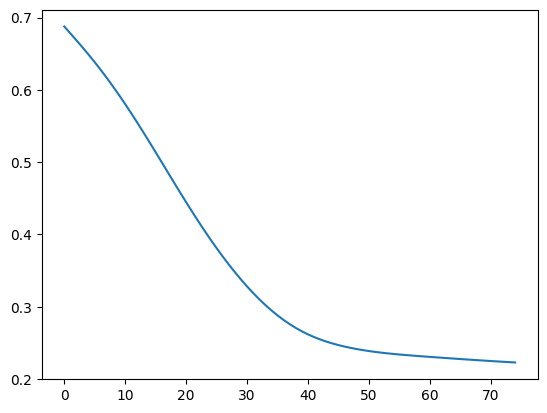

In [ ]:
def plot_loss_curve(loss):
  plt.plot([l.detach().numpy() for l in loss])

plot_loss_curve(loss_his)